# Interpolating data remotely with ERDDAP

ERDDAP servers can do a lot on the server side.
One functionality that can surprise even advanced users is the [ability to interpolate data](https://coastwatch.pfeg.noaa.gov/erddap/convert/interpolate.html).

The API is relatively simple.
We need to provide a table of `"time,longitude,latitude"` we want to interpolate,
a gridded dataset to interpolate from that is served in ERDDAP's griddap,
and the interpolation method.

In this example we will fetch the data for the Saildrone Hurricane Monitoring 2021 NRT data (drone 1031) and interpolate temperature from the Multi-scale Ultra-high Resolution (MUR) SST Analysis to the saildrone track points.

First we need to get the saildrone data:

In [1]:
from erddapy import ERDDAP


server = "https://data.pmel.noaa.gov/pmel/erddap"
protocol = "tabledap"
dataset_id = "sd1031_hurricane_2021"

variables = ["latitude", "longitude", "time", "TEMP_SBE37_MEAN"]

constraints = {
    "time>=": "now-30days",
}

e = ERDDAP(server=server, protocol=protocol)
e.dataset_id = dataset_id
e.variables = variables
e.constraints = constraints

df = e.to_pandas()

The original data frequency is very high. Before we send the interpolation request let's re-sample it to daily data to reduce the number of data points.

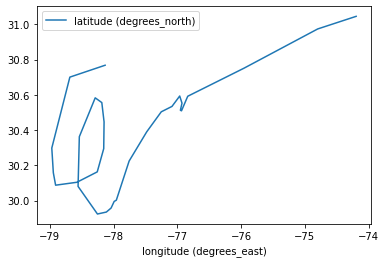

In [2]:
import pandas as pd


df["time (UTC)"] = pd.to_datetime(df["time (UTC)"])
df = df.set_index("time (UTC)")
df = df.dropna()
df = df.resample("1D").mean()


df.plot(x="longitude (degrees_east)", y="latitude (degrees_north)");

We need to prepare the data to send to the server. As mentioned above the request will take a table with a header `"time,latitude,longitude"`, then its values. Note that we save a text time column and then rename the columns to create the request.

In [3]:
df["time"] = df.index.strftime("%Y-%m-%dT%H:%M:%SZ")
rdf = df[["time", "latitude (degrees_north)", "longitude (degrees_east)"]]
rdf.columns = ["time", "latitude", "longitude"]

time_lat_lon = rdf.to_csv(index=False)
print(time_lat_lon)

time,latitude,longitude
2021-09-19T00:00:00Z,31.045235074157304,-74.19571627865169
2021-09-20T00:00:00Z,30.973748331707316,-74.79874661463415
2021-09-21T00:00:00Z,30.7513994247191,-75.95385661123595
2021-09-22T00:00:00Z,30.592158453333333,-76.83690204444444
2021-09-23T00:00:00Z,30.509671324444444,-76.93471043555556
2021-09-24T00:00:00Z,30.512786067415732,-76.9521364494382
2021-09-25T00:00:00Z,30.553165922077923,-76.92701739220779
2021-09-26T00:00:00Z,30.593412853932584,-76.96289729438202
2021-09-27T00:00:00Z,30.53456570909091,-77.08399632727273
2021-09-28T00:00:00Z,30.503939466666665,-77.25222378666666
2021-09-29T00:00:00Z,30.39036503111111,-77.48038044444444
2021-09-30T00:00:00Z,30.224735441860467,-77.7561886511628
2021-10-01T00:00:00Z,30.002958471910112,-77.95673499325842
2021-10-02T00:00:00Z,29.995775836363634,-77.99072541818181
2021-10-03T00:00:00Z,29.958422975280897,-78.03892469213483
2021-10-04T00:00:00Z,29.93563616744186,-78.11308651162791
2021-10-05T00:00:00Z,29.924510509090908

The cell below builds the request and download get it back as a pandas dataframe.

In [4]:
from urllib.parse import quote_plus


# See https://coastwatch.pfeg.noaa.gov/erddap/convert/interpolate.html
# for more infor on the options available
response = "csv"
dataset_id = "jplMURSST41"
variable = "analysed_sst"
algorithm = "Bilinear"
nearby = 4

url = (
    "https://coastwatch.pfeg.noaa.gov/erddap/"
    f"convert/interpolate.{response}?"
    f"TimeLatLonTable={quote_plus(time_lat_lon)}"
    f"&requestCSV={dataset_id}/{variable}/{algorithm}/{nearby}"
)


idf = pd.read_csv(url)

Now we have a new dataframe with interpolated values! Let's add a column with the saildrone data, drop NaNs, and make a few simple comparisons.

In [5]:
idf["saildrone"] = df["TEMP_SBE37_MEAN (degree_C)"].values
idf.dropna(inplace=True)

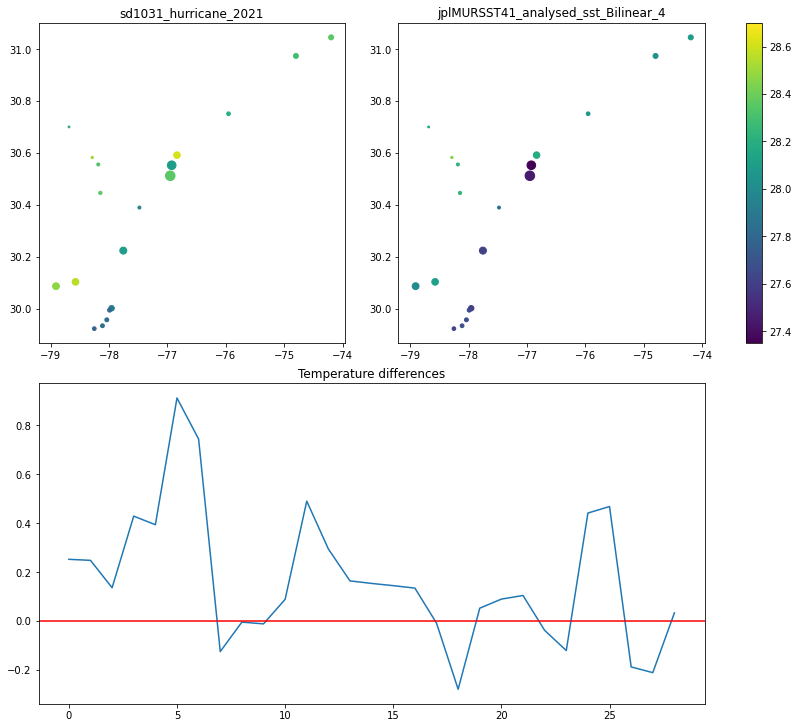

In [7]:
import matplotlib.pyplot as plt


fig = plt.figure(
    constrained_layout=True,
    figsize=(11, 10),
)

axes = fig.subplot_mosaic(
    """
    AB
    CC
    """
)

vmin, vmax = 27.35, 28.7,
diff = idf["saildrone"] - idf["jplMURSST41_analysed_sst_Bilinear_4"]

cs0 = axes["A"].scatter(
    idf["longitude"],
    idf["latitude"],
    c=idf["saildrone"],
    s=diff*1e2,
    vmin=vmin, vmax=vmax,
)
axes["A"].set_title("sd1031_hurricane_2021")

cs1 = axes["B"].scatter(
    idf["longitude"],
    idf["latitude"],
    c=idf["jplMURSST41_analysed_sst_Bilinear_4"],
    s=diff*1e2,
    vmin=vmin, vmax=vmax,
)
axes["B"].set_title("jplMURSST41_analysed_sst_Bilinear_4")

fig.colorbar(cs0, ax=[axes["A"], axes["B"]], location="right")

axes["C"].plot(diff)
axes["C"].axhline(y=0, color="red")
axes["C"].set_title("Temperature differences");

We don't have enough for a meaningful analysis here but it looks like the saildrone sensor has higher temperatures than the gridded dataset and that the differences are higher (bigger circles) when the drone was in the middle of the hurricane (that knot in the middle of the track).